In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


import torch
import torch.nn as nn
import torch.optim as optim

データの準備

In [32]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)
df.head()

,kmeans_dist,kmeans_cluster,dbscan_cluster,pca_1,pca_2,anomaly_score,nearest_cosine_similarity,dengue
0,0.807903,1.00,0.000000,0.690117,0.530614,1.0,0.248749,1.0
1,0.872944,0.25,0.000378,0.548990,0.361146,1.0,0.372575,0.0
2,0.811521,0.00,0.000755,0.402503,0.733854,1.0,0.528842,0.0
3,0.809303,1.00,0.001133,0.472950,0.346633,0.0,0.441506,0.0
4,0.815355,0.00,0.001511,0.601353,0.324567,1.0,0.329382,1.0


In [33]:
X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

深層学習モデル

In [34]:
class DNN_1(nn.Module):
    def __init__(self, input_dim):
        super(DNN_1, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.layer2 = nn.Linear(256,128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 32)
        
        self.dropout = nn.Dropout(p=0.2)

        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)

        x=torch.relu(self.layer2(x))
        x = self.dropout(x)


        x = torch.relu(self.layer3(x))
        
        x=torch.relu(self.layer4(x))

        x = torch.sigmoid(self.output_layer(x)) 
        return x

In [35]:
class DNN_2(nn.Module):
    def __init__(self, input_dim):
        super(DNN_2, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.layer2 = nn.Linear(256,128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 32)
        
        self.dropout = nn.Dropout(p=0.2)

        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        
        x=torch.relu(self.layer2(x))
        x=self.dropout(x)
         
        x = torch.relu(self.layer3(x))
        x = self.dropout(x)

        x = torch.relu(self.layer4(x))

        x = torch.sigmoid(self.output_layer(x)) 
        return x

In [36]:
class DNN_3(nn.Module):
    def __init__(self, input_dim):
        super(DNN_3, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.layer2 = nn.Linear(256,128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 32)

        self.dropout = nn.Dropout(p=0.2)

        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        
        x=torch.relu(self.layer2(x))

        x = torch.relu(self.layer3(x))
        x=self.dropout(x)
        
        x = torch.relu(self.layer4(x))
        x = self.dropout(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x

In [37]:
# モデルの初期化
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_tensor.shape[1]

DNN_1=DNN_1(input_dim=input_dim).to(device)
DNN_2=DNN_2(input_dim=input_dim).to(device)
DNN_3=DNN_3(input_dim=input_dim).to(device)

# 損失関数と最適化
DNN_1_optim = optim.Adam(DNN_1.parameters(), lr=0.001)
DNN_2_optim = optim.Adam(DNN_2.parameters(), lr=0.001)
DNN_3_optim = optim.Adam(DNN_3.parameters(), lr=0.001)

criterion = nn.BCELoss()


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

train_losses_per_model = [] 

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)

val_losses_per_model = [] 

In [ ]:
#DNN1の学習
num_epochs = 100

print(f"Training model: DNN1")

DNN_1.train()  
train_losses = []
val_losses = []
train_losses_per_model = []  

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        DNN_1_optim.zero_grad()

        outputs = DNN_1(X_batch).squeeze()
        loss = criterion(outputs, y_batch)

        loss.backward()
        DNN_1_optim.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    if val_loader is not None:
        DNN_1.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = DNN_1(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        DNN_1.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")


train_losses_per_model.append([train_losses])


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Training model: DNN1


/opt/conda/conda-bld/pytorch_1728945388038/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [1,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1728945388038/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [20,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1728945388038/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [32,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1728945388038/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [34,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1728945388038/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [46,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1728945388038/work/aten/src

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Training model: DNN2


Epoch [1/200], Train Loss: 0.6308, Val Loss: 0.5880
Epoch [2/200], Train Loss: 0.5724, Val Loss: 0.5710
Epoch [3/200], Train Loss: 0.5684, Val Loss: 0.5741
Epoch [4/200], Train Loss: 0.5615, Val Loss: 0.5640
Epoch [5/200], Train Loss: 0.5606, Val Loss: 0.5666
Epoch [6/200], Train Loss: 0.5541, Val Loss: 0.5715
Epoch [7/200], Train Loss: 0.5525, Val Loss: 0.5670
Epoch [8/200], Train Loss: 0.5510, Val Loss: 0.5590
Epoch [9/200], Train Loss: 0.5484, Val Loss: 0.5505
Epoch [10/200], Train Loss: 0.5454, Val Loss: 0.5589
Epoch [11/200], Train Loss: 0.5421, Val Loss: 0.5659
Epoch [12/200], Train Loss: 0.5342, Val Loss: 0.5575
Epoch [13/200], Train Loss: 0.5303, Val Loss: 0.5608
Epoch [14/200], Train Loss: 0.5266, Val Loss: 0.5744
Epoch [15/200], Train Loss: 0.5212, Val Loss: 0.5625
Epoch [16/200], Train Loss: 0.5099, Val Loss: 0.5715
Epoch [17/200], Train Loss: 0.5010, Val Loss: 0.5859
Epoch [18/200], Train Loss: 0.4987, Val Loss: 0.6177
Epoch [19/200], Train Loss: 0.4871, Val Loss: 0.6246
Ep

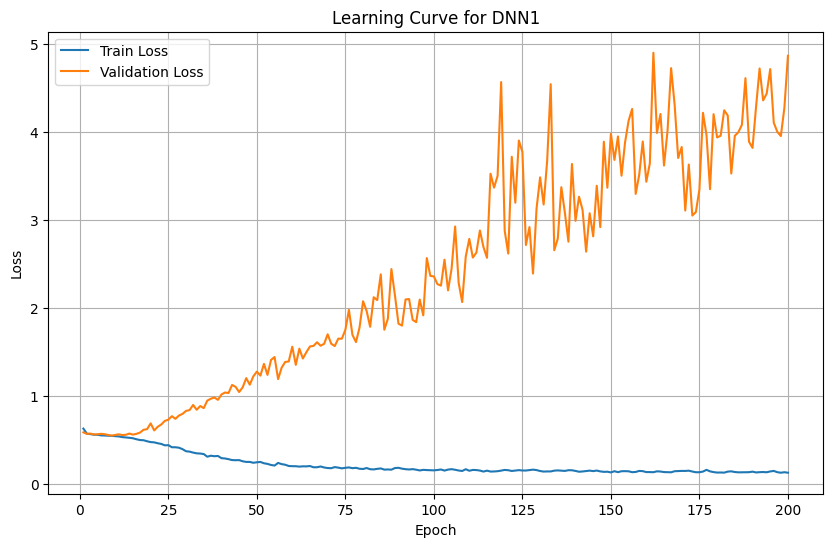

In [ ]:
#DNN1の学習
num_epochs = 100

print(f"Training model: DNN2")

DNN_2.train()  
train_losses = []
val_losses = []
train_losses_per_model = []  

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        DNN_2_optim.zero_grad()

        outputs = DNN_2(X_batch).squeeze()
        loss = criterion(outputs, y_batch)

        loss.backward()
        DNN_2_optim.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    if val_loader is not None:
        DNN_2.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = DNN_2(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        DNN_2.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")


train_losses_per_model.append([train_losses])


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Training model: DNN1
Epoch [1/200], Train Loss: 0.6430, Val Loss: 0.5822
Epoch [2/200], Train Loss: 0.5712, Val Loss: 0.5707
Epoch [3/200], Train Loss: 0.5664, Val Loss: 0.5701
Epoch [4/200], Train Loss: 0.5630, Val Loss: 0.5601
Epoch [5/200], Train Loss: 0.5614, Val Loss: 0.5593
Epoch [6/200], Train Loss: 0.5566, Val Loss: 0.5559
Epoch [7/200], Train Loss: 0.5531, Val Loss: 0.5564
Epoch [8/200], Train Loss: 0.5499, Val Loss: 0.5588
Epoch [9/200], Train Loss: 0.5482, Val Loss: 0.5428
Epoch [10/200], Train Loss: 0.5471, Val Loss: 0.5753
Epoch [11/200], Train Loss: 0.5371, Val Loss: 0.5622
Epoch [12/200], Train Loss: 0.5376, Val Loss: 0.5602
Epoch [13/200], Train Loss: 0.5335, Val Loss: 0.5687
Epoch [14/200], Train Loss: 0.5235, Val Loss: 0.5711
Epoch [15/200], Train Loss: 0.5263, Val Loss: 0.5592
Epoch [16/200], Train Loss: 0.5095, Val Loss: 0.5912
Epoch [17/200], Train Loss: 0.5005, Val Loss: 0.5974
Epoch [18/200], Train Loss: 0.5013, Val Loss: 0.5937
Epoch [19/200], Train Loss: 0.4909

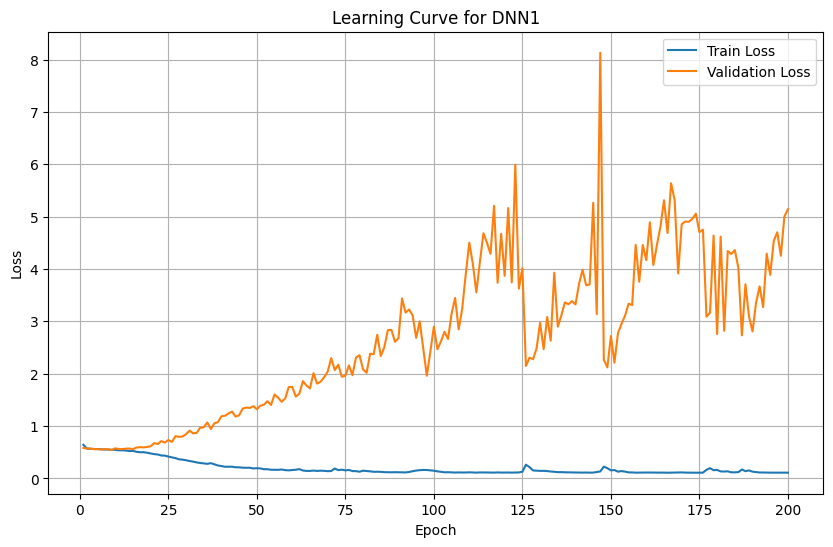

In [ ]:
#DNN3の学習
num_epochs = 100

print(f"Training model: DNN1")

DNN_3.train()  
train_losses = []
val_losses = []
train_losses_per_model = []  

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        DNN_3_optim.zero_grad()

        outputs = DNN_3(X_batch).squeeze()
        loss = criterion(outputs, y_batch)

        loss.backward()
        DNN_3_optim.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    if val_loader is not None:
        DNN_3.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = DNN_3(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        DNN_3.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")


train_losses_per_model.append([train_losses])


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

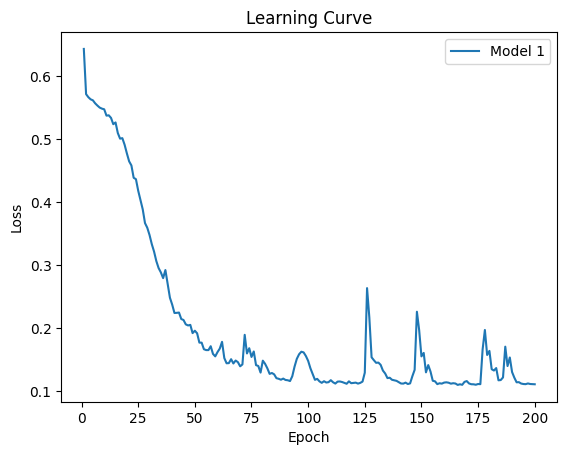

In [ ]:
# 学習曲線
for model_idx, losses in enumerate(train_losses_per_model):
    plt.plot(range(1, num_epochs + 1), losses, label=f'Model {model_idx + 1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()



--- Evaluating Model 1 ---

Accuracy: 59.00%
Precision: 0.4692
Recall: 0.4720
F1 Score: 0.4706
Matthews Correlation Coefficient: 0.1360
Specificity: 0.6642


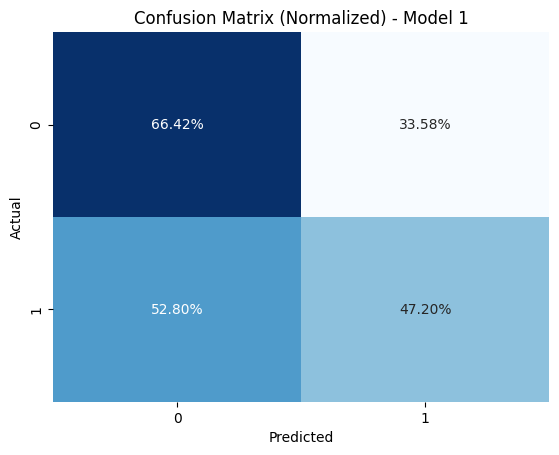

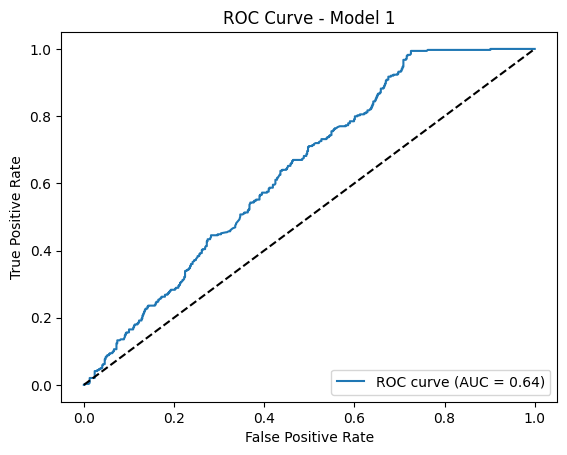

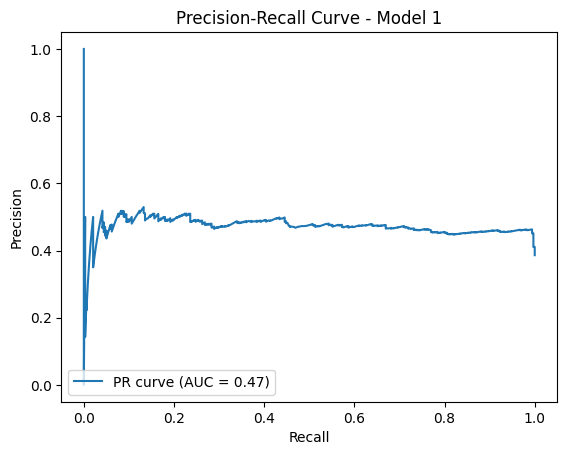


--- Evaluating Model 2 ---

Accuracy: 59.91%
Precision: 0.4807
Recall: 0.4779
F1 Score: 0.4793
Matthews Correlation Coefficient: 0.1534
Specificity: 0.6753


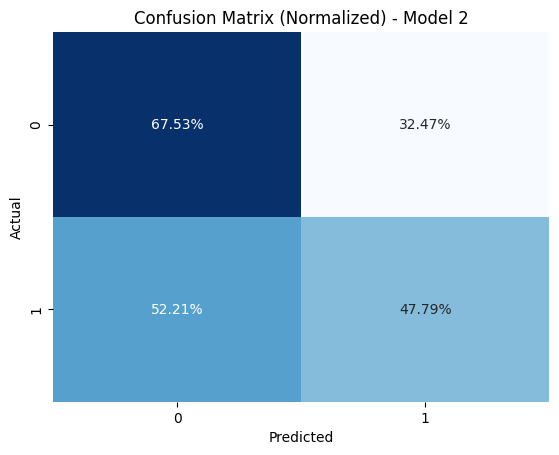

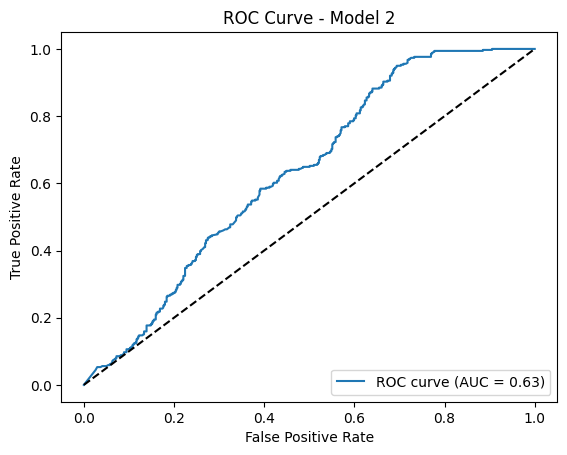

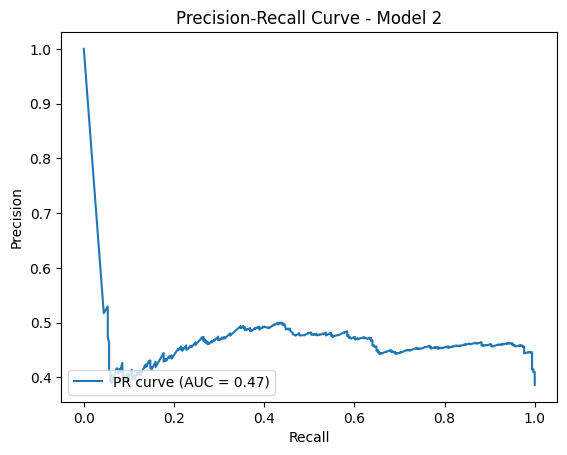


--- Evaluating Model 3 ---

Accuracy: 57.86%
Precision: 0.4561
Recall: 0.4749
F1 Score: 0.4653
Matthews Correlation Coefficient: 0.1179
Specificity: 0.6438


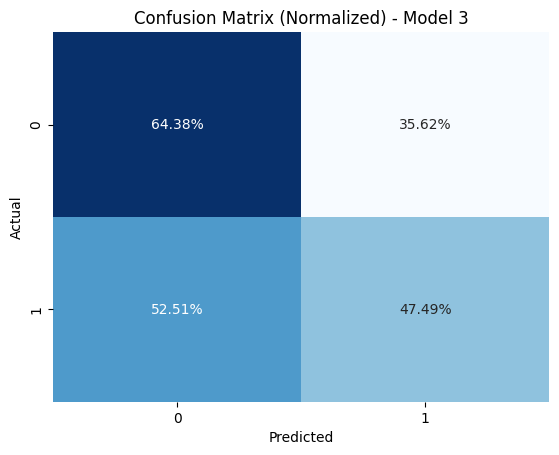

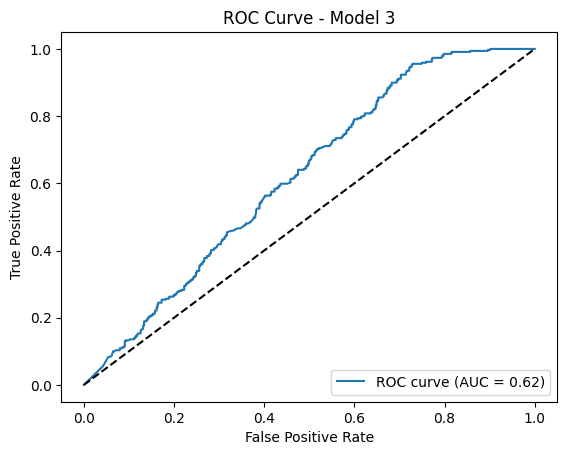

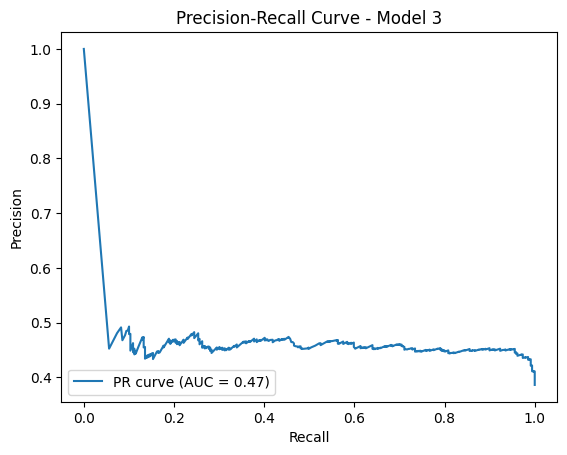

In [ ]:
models=[DNN_1,DNN_2,DNN_3]

# 評価を各モデルで実施
for idx, model in enumerate(models):
    print(f"\n--- Evaluating Model {idx + 1} ---\n")
    
    model.eval()
    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        y_test_tensor = y_test_tensor.to(device)

        # 予測と確率
        test_outputs = model(X_test_tensor).squeeze()
        predictions = (test_outputs >= 0.5).float()
        y_true = y_test_tensor.cpu().numpy()
        y_pred = predictions.cpu().numpy()
        y_prob = test_outputs.cpu().numpy()

        # 評価指標
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        mcc = matthews_corrcoef(y_true, y_pred)
        specificity = recall_score(y_true, y_pred, pos_label=0)  
        print(f'Accuracy: {accuracy * 100:.2f}%')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f'Matthews Correlation Coefficient: {mcc:.4f}')
        print(f'Specificity: {specificity:.4f}')

        # 混同行列（割合表示）
        cm = confusion_matrix(y_true, y_pred, normalize='true')
        sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix (Normalized) - Model {idx + 1}")
        plt.show()

        # ROC曲線とAUC
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--') 
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Model {idx + 1}')
        plt.legend(loc="lower right")
        plt.show()

        # Precision-Recall曲線
        precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recall_curve, precision_curve)
        plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - Model {idx + 1}')
        plt.legend(loc="lower left")
        plt.show()

In [ ]:
# 学習用スタッキングデータ
DNN1_preds = DNN_1(X_train_tensor.to(device)).cpu().detach().numpy().squeeze()
DNN2_preds = DNN_2(X_train_tensor.to(device)).cpu().detach().numpy().squeeze()
DNN3_preds = DNN_3(X_train_tensor.to(device)).cpu().detach().numpy().squeeze()


train_stacked_features = np.column_stack((DNN1_preds, DNN2_preds,DNN3_preds))
train_stacked_labels=y_train

# テスト用スタッキングデータ
DNN1_preds = DNN_1(X_test_tensor.to(device)).cpu().detach().numpy().squeeze()
DNN2_preds = DNN_2(X_test_tensor.to(device)).cpu().detach().numpy().squeeze()
DNN3_preds = DNN_3(X_test_tensor.to(device)).cpu().detach().numpy().squeeze()

test_stacked_features = np.column_stack((DNN1_preds, DNN2_preds, DNN3_preds))
test_stacked_labels=y_test




In [ ]:
meta_model=SVC(kernel='rbf',probability=True)
meta_model.fit(train_stacked_features,train_stacked_labels)

SVC(probability=True)

Accuracy: 58.31%
Precision: 0.4548
Recall: 0.4012
F1 Score: 0.4263
Matthews Correlation Coefficient: 0.1015
Specificity: 0.6976
AUC Score: 0.5675


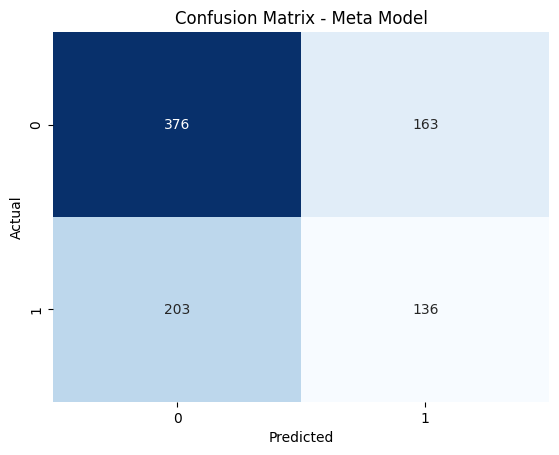

In [ ]:
# メタモデルの評価
stack_val_preds = meta_model.predict_proba(test_stacked_features)[:, 1]
stack_val_predictions = (stack_val_preds > 0.49).astype(int)

# 評価指標の計算
accuracy = accuracy_score(test_stacked_labels, stack_val_predictions)
precision = precision_score(test_stacked_labels, stack_val_predictions)
recall = recall_score(test_stacked_labels, stack_val_predictions)
f1 = f1_score(test_stacked_labels, stack_val_predictions)
mcc = matthews_corrcoef(test_stacked_labels, stack_val_predictions)
specificity = recall_score(test_stacked_labels, stack_val_predictions, pos_label=0)
auc_score = roc_auc_score(test_stacked_labels, stack_val_preds)

# 結果を出力
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Matthews Correlation Coefficient: {mcc:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f"AUC Score: {auc_score:.4f}")

# スタッキングモデルの混同行列表示
stack_cm = confusion_matrix(test_stacked_labels, stack_val_predictions)
sns.heatmap(stack_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Meta Model")
plt.show()
